# Analysis of distribution assumptions in BoxCar opperations

In [ ]:
# importing the necessary libraries

from matplotlib import pyplot as plt
from scipy.stats import chi2
import pandas as pd
import numpy as np
import seaborn as sns
from icecream import ic
import os
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Import the data from the xlsx files
drivers_file = os.path.join('.','drivers.xlsx')
riders_file = os.path.join('.','riders.xlsx')
driver_data = pd.read_excel(drivers_file)
rider_data = pd.read_excel(riders_file)

# Print variable names for the data
ic(list(driver_data.columns))
ic(list(rider_data.columns))

DATA_CLEANED = False

ic| list(driver_data.columns): ['id', 'initial_location', 'arrival_datetime', 'offline_datetime']
ic| list(rider_data.columns): ['id',
                               'pickup_location',
                               'dropoff_location',
                               'status',
                               'request_datetime',
                               'pickup_datetime',
                               'dropoff_datetime']


In [3]:
# Data Cleaning
rider_location_variables : list[str]  = ['pickup_location', 'dropoff_location']
driver_location_variables : list[str] = ['initial_location']

def string_to_double_tuple(string : str)->tuple:
    return tuple(map(float, string[1:-1].split(', ')))

# Convert all location columns to tuples
if not DATA_CLEANED:
    for column in rider_location_variables:
        rider_data[column] = rider_data[column].apply(string_to_double_tuple)
    for column in driver_location_variables:
        driver_data[column] = driver_data[column].apply(string_to_double_tuple)
    DATA_CLEANED = True

TODO: Establish a method for testing inter-arrival times for riders and drivers. They are both said to be exponentially distributed with λ = 30/hour for riders and λ = 3/hour for drivers. Test the null hypothesis that the inter-arrival times are exponentially distributed with the given λ values.

TODO: Establish a methods to test the null hypothesis that the driver working times are uniformly distributed between 5 and 8 hours. 

TODO: Perform analysis on the location variables to see if we can determine the distribution of each the location variables. 

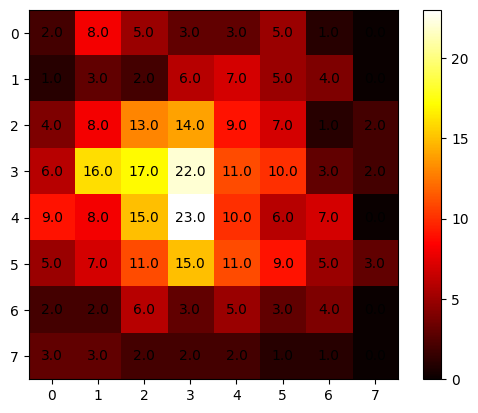

The locations are not uniformly distributed


False

In [4]:
# disable icecream
ic.disable()

# Location variable uniformty check
def check_location_variable_uniformity(location_data : list[tuple[float,float]], plots = False)->bool:
    '''
    We are checking if the locations are uniformly distributed. 
    The assumption is all location variable are uniformly distributed 
    with distribution U(0,20) x U(0,20). 

    We will use a serial test with the following hypothesis:
    H0: L = U(0,20) x U(0,20) where both U(0,20) are independent.
    H1: L != U(0,20) x U(0,20)

    This is similar to the chi-square test for uniformity in 2D.
    '''

    # Get the number of observations and the number of bins
    number_of_observations = len(location_data)
    k = int(np.floor(np.sqrt(number_of_observations/5)))
    ic(number_of_observations)
    ic(k)

    # Create the bins
    bin_edges = np.linspace(0,20,k+1)
    ic(bin_edges)
    
    # Create the histogram
    x, y = zip(*location_data)
    H, _, _ = np.histogram2d(x=x, y=y, bins=(bin_edges, bin_edges))
    H = np.flip(H,1)
    ic(H)

    # Calculate the expected values
    n = number_of_observations
    expected_values = n/(k**2)
    ic(expected_values)

    # Calculate the test statistic
    test_statistic = np.sum((H-expected_values)**2/expected_values)
    ic(test_statistic)

    # Calculate the critical value
    critical_value = chi2.ppf(0.95, k**2)
    ic(critical_value)

    # Plot the histogram
    if plots:
        # Plot the histogram
        plt.imshow(H, cmap='hot', interpolation='nearest')
        # add numbers to the heatmap
        for i in range(k):
            for j in range(k):
                plt.text(j, i, H[i, j], ha='center', va='center', color='black')
        plt.colorbar()
        plt.show()

    # Check if the test statistic is greater than the critical value
    if test_statistic > critical_value:
        print('The locations are not uniformly distributed')
        return False
    else:
        print('The locations are uniformly distributed')
        return True
    
# Testing the function 
check_location_variable_uniformity(driver_data['initial_location'], True)

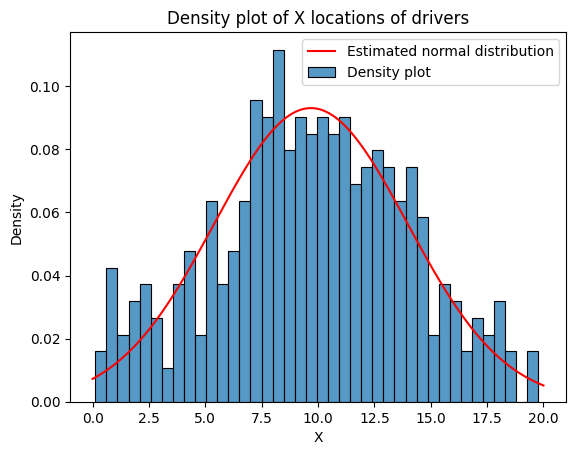

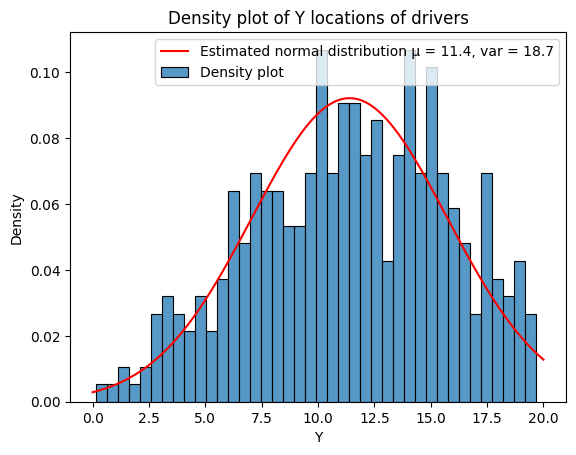

In [5]:
# Plot histogram of the initial x and y locations of the drivers

x, y = zip(*driver_data['initial_location'])

k = 40 # number of bins

# Estimate the mean and variance of the initial x and y locations of the drivers
mean_x = np.mean(x)
mean_y = np.mean(y)
var_x = np.var(x)
var_y = np.var(y)

ic(mean_x, mean_y, var_x, var_y)

# # X histogram overlayed with the normal distribution with ~ N(mean_x, var_x)
# plt.hist(x, bins=k)
# plt.xlabel('X')
# plt.ylabel('Frequency')
# plt.title('Histogram of X locations of drivers')
# plt.show()

# # Y histogram
# plt.hist(y, bins=k)
# plt.xlabel('Y')
# plt.ylabel('Frequency')
# plt.title('Histogram of Y locations of drivers')
# plt.show()

# # Plot normal distribution with x_mean and x_var
# x_values = np.linspace(0,20,1000)
# y_values = (1/np.sqrt(2*np.pi*var_x))*np.exp(-0.5*(x_values-mean_x)**2/var_x)
# plt.plot(x_values, y_values)
# plt.xlabel('X')
# plt.ylabel('Density')
# plt.title('Normal distribution of X locations of drivers')
# plt.show()

# Fit a to the x locations of the drivers and overlay the estimated normal distribution
sns.histplot(x, kde=False, stat='density', bins=k)
x_values = np.linspace(0,20,1000)
y_values = (1/np.sqrt(2*np.pi*var_x))*np.exp(-0.5*(x_values-mean_x)**2/var_x)
plt.plot(x_values, y_values, 'r')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Density plot of X locations of drivers')
plt.legend(['Estimated normal distribution', 'Density plot'])
plt.show()

# Fit a to the y locations of the drivers and overlay the estimated normal distribution
sns.histplot(y, kde=False, stat='density', bins=k)
y_values = (1/np.sqrt(2*np.pi*var_y))*np.exp(-0.5*(x_values-mean_y)**2/var_y)
plt.plot(x_values, y_values, 'r')
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Density plot of Y locations of drivers')
plt.legend([f'Estimated normal distribution μ = {mean_y:.1f}, var = {var_y:.1f}', 'Density plot'])
plt.show()


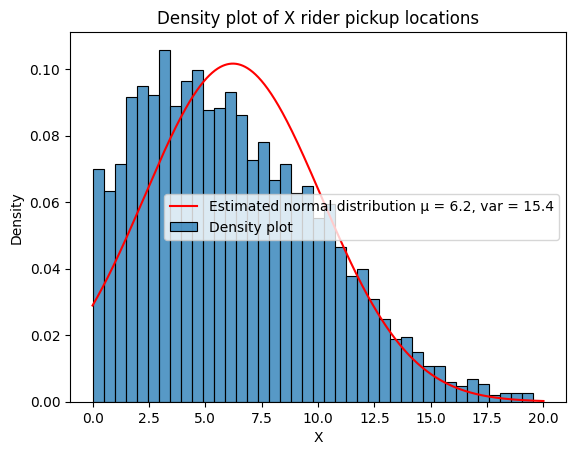

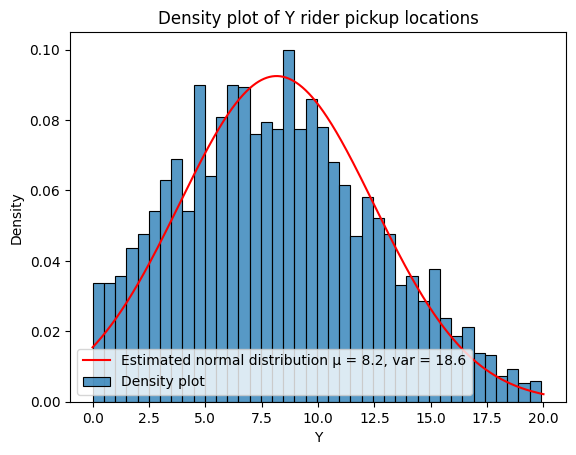

In [6]:
def plot_x_y_hist(locations, title, distribution=None, bins=40):
    x, y = zip(*locations)
    if distribution == 'normal':
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        var_x = np.var(x)
        var_y = np.var(y)
        values = np.linspace(0,20,1000)
        x_values = (1/np.sqrt(2*np.pi*var_x))*np.exp(-0.5*(values-mean_x)**2/var_x)
        y_values = (1/np.sqrt(2*np.pi*var_y))*np.exp(-0.5*(values-mean_y)**2/var_y)


    sns.histplot(x, kde=False, stat='density', bins=bins)
    if distribution: 
        plt.plot(values, x_values, 'r')
        plt.legend([f'Estimated normal distribution μ = {mean_x:.1f}, var = {var_x:.1f}', 'Density plot'])
    plt.xlabel('X')
    plt.ylabel('Density')
    plt.title(f'Density plot of X {title}')
    plt.show()

    sns.histplot(y, kde=False, stat='density', bins=bins)
    if distribution: 
        plt.plot(values, y_values, 'r')
        plt.legend([f'Estimated normal distribution μ = {mean_y:.1f}, var = {var_y:.1f}', 'Density plot'])
    plt.xlabel('Y')
    plt.ylabel('Density')
    plt.title(f'Density plot of Y {title}')
    plt.show()

locations = rider_data['pickup_location']
plot_x_y_hist(locations, title='rider pickup locations', distribution='normal')

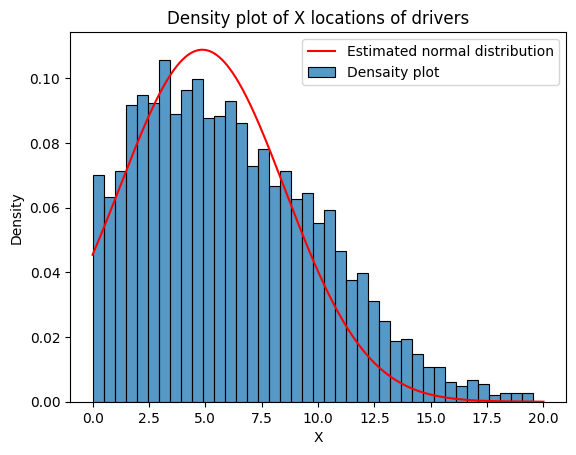

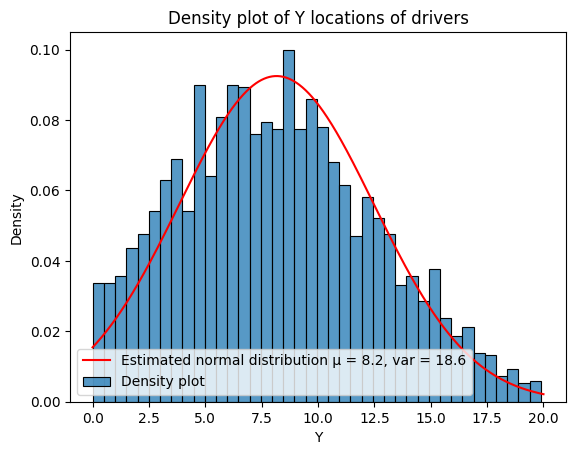

In [7]:
import scipy.stats as stats
# Plot histogram of the initial x and y locations of the drivers

x, y = zip(*rider_data['pickup_location'])

k = 40 # number of bins

# Estimate the mean and variance of the initial x and y locations of the drivers
mean_x = np.mean(x)
mean_y = np.mean(y)
var_x = np.var(x)
var_y = np.var(y)

ic(mean_x, mean_y, var_x, var_y)

def normal_distribution(x, mean, var):
    return (1/np.sqrt(2*np.pi*var))*np.exp(-0.5*(x-mean)**2/var)

# Fit a to the x locations of the drivers and overlay the estimated normal distribution
sns.histplot(x, kde=False, stat='density', bins=k)
values = np.linspace(0,20,1000)

x_values = stats.skewnorm.pdf(values, a=-0.5, loc=mean_x, scale=np.sqrt(var_x))
# x_values = stats.lognorm(s=npa.sqrt(var_x), scale=np.exp(mean_x)).pdf(values)
plt.plot(values, x_values, 'r')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Density plot of X locations of drivers')
plt.legend(['Estimated normal distribution', 'Densaity plot'])
plt.show()

# Fit a to the y locations of the drivers and overlay the estimated normal distribution
sns.histplot(y, kde=False, stat='density', bins=k)
y_values = normal_distribution(values, mean_y, var_y)
plt.plot(values, y_values, 'r')
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Density plot of Y locations of drivers')
plt.legend([f'Estimated normal distribution μ = {mean_y:.1f}, var = {var_y:.1f}', 'Density plot'])
plt.show()


2025-02-25 11:59:30.755 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.017293)
2025-02-25 11:59:30.767 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=0.009853)
2025-02-25 11:59:31.291 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.020182)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.009853,701.420802,725.499254,inf,0.017863,0.283200
gamma,0.017293,694.566997,712.625835,inf,0.038204,0.000272
lognorm,0.020182,702.068299,720.127138,inf,0.039607,0.000140


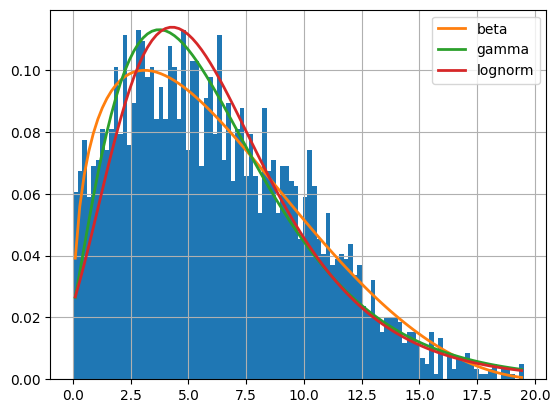

In [20]:
x, y = zip(*rider_data['pickup_location'])
f = Fitter(x,
           distributions=[
               'gamma',
                'lognorm',
                # 'skewnorm',
                # 'norm',
                # 'expon',
                # 'uniform',
                'beta'
           ])
f.fit()
f.summary()

In [21]:
f.get_best(method='sumsquare_error')

{'beta': {'a': 1.40358104356006,
  'b': 3.290111407192441,
  'loc': -0.028116888578053605,
  'scale': 20.82068845569975}}

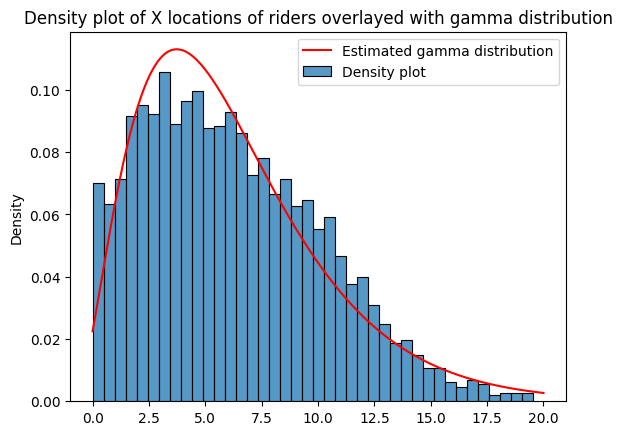

In [15]:
a, loc, scale = f.fitted_param['gamma']
x_values = np.linspace(0,20,1000)
y_values = stats.gamma.pdf(x_values, a=a, loc=loc, scale=scale)
sns.histplot(x, kde=False, stat='density', bins=k)
plt.plot(x_values, y_values, 'r')
plt.title('Density plot of X locations of riders overlayed with gamma distribution')
plt.legend(['Estimated gamma distribution', 'Density plot'])
plt.show()

2025-02-25 15:17:06.840 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.069607)
2025-02-25 15:17:06.848 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.225808)
2025-02-25 15:17:06.855 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.138005)
2025-02-25 15:17:06.858 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.069607)
2025-02-25 15:17:06.870 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.069402)


Best fit for driver initial X locations: skewnorm
Parameters: {'a': -0.6553385532108855, 'loc': 11.769853403784328, 'scale': 4.7665348066929445}


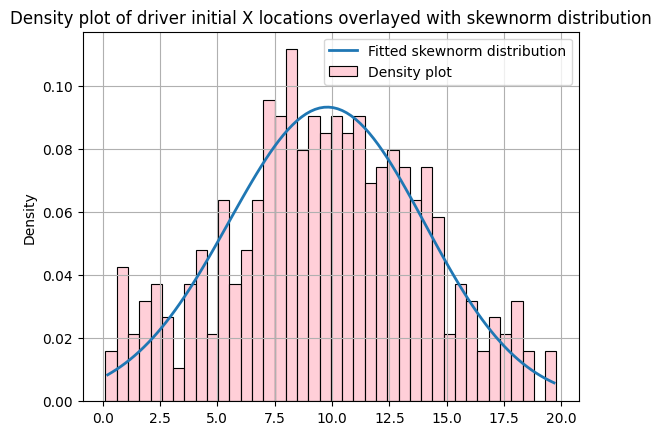

2025-02-25 15:17:07.074 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.068946)
2025-02-25 15:17:07.096 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.245169)
2025-02-25 15:17:07.096 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.123585)
2025-02-25 15:17:07.103 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.068946)
2025-02-25 15:17:07.103 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.068363)


Best fit for driver initial Y locations: skewnorm
Parameters: {'a': -1.8613468402067674, 'loc': 15.741154707299845, 'scale': 6.130900015620162}


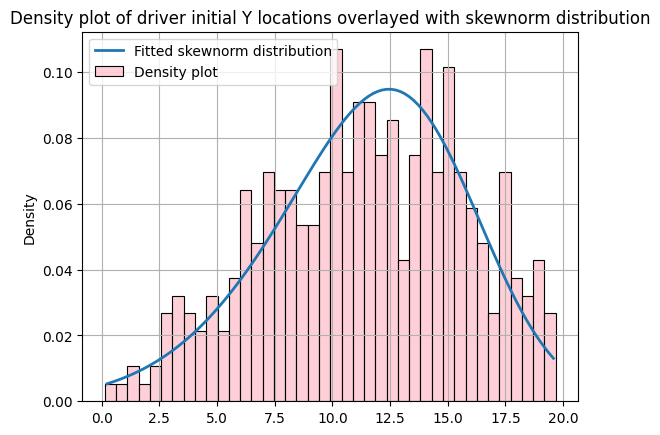

2025-02-25 15:17:07.359 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.020182)
2025-02-25 15:17:07.368 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.08007)
2025-02-25 15:17:07.371 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.031124)
2025-02-25 15:17:07.382 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.128062)
2025-02-25 15:17:07.411 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.018249)


Best fit for rider pickup X locations: skewnorm
Parameters: {'a': 11.70214787952497, 'loc': 0.5548065474669168, 'scale': 6.894640009566302}


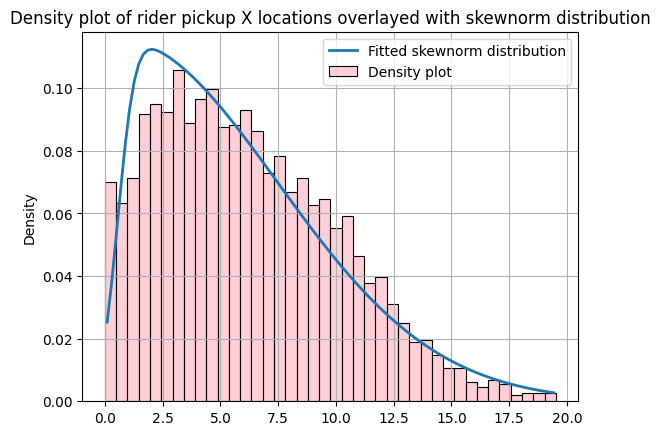

Best fit for rider pickup Y locations: lognorm
Parameters: {'s': 0.15864605752265049, 'loc': -19.067260918536068, 'scale': 26.88939125862763}


2025-02-25 15:17:07.844 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.012931)
2025-02-25 15:17:07.847 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.118832)
2025-02-25 15:17:07.850 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.077286)
2025-02-25 15:17:07.855 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.014302)
2025-02-25 15:17:07.877 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.013703)


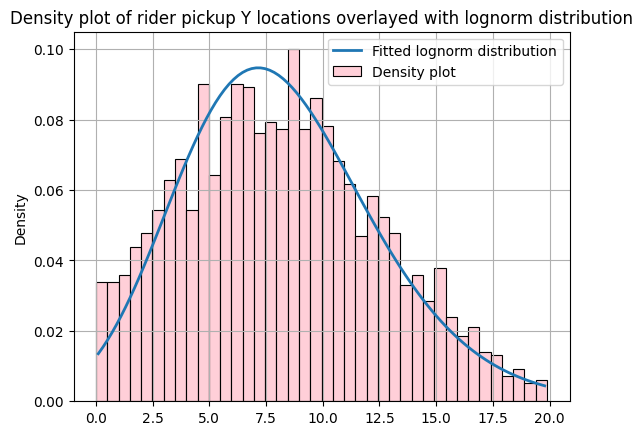

2025-02-25 15:17:08.038 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.013226)
2025-02-25 15:17:08.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.126671)
2025-02-25 15:17:08.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.056051)
2025-02-25 15:17:08.045 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.013334)
2025-02-25 15:17:08.119 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.013332)


Best fit for rider dropoff X locations: lognorm
Parameters: {'s': 0.07511460654824867, 'loc': -51.778264575561884, 'scale': 60.913014003772645}


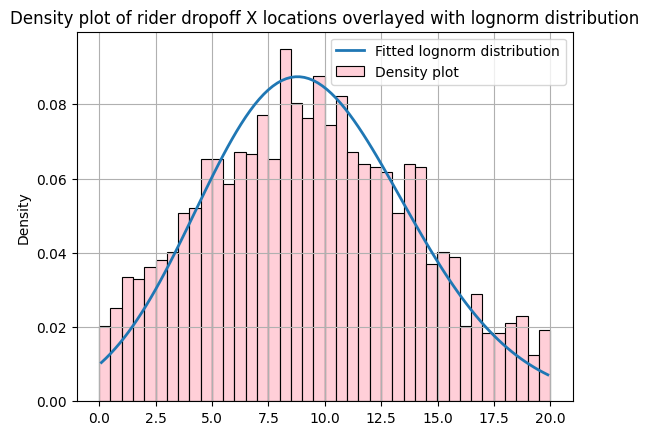

2025-02-25 15:17:08.296 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.172306)
2025-02-25 15:17:08.296 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.013113)
2025-02-25 15:17:08.300 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.059096)
2025-02-25 15:17:08.302 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.013112)
2025-02-25 15:17:08.331 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=0.012862)


Best fit for rider dropoff Y locations: skewnorm
Parameters: {'a': -1.72800349986821, 'loc': 15.703349415970072, 'scale': 6.2423123375142}


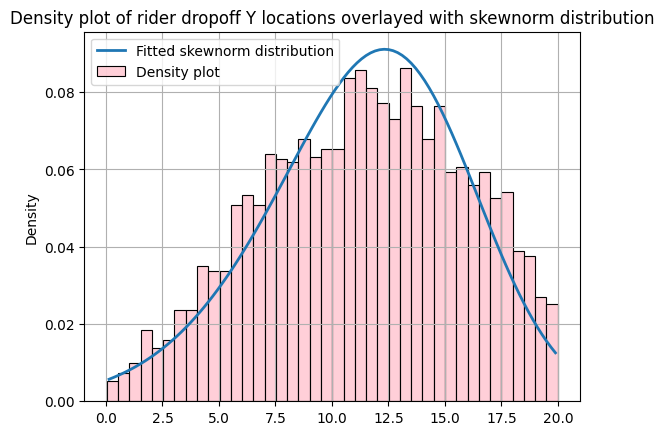

In [100]:
def fit_and_plot(data, data_name):
    distributions = [
        # 'gamma', 
        # 'beta', 
        'lognorm', 
        'expon', 
        'uniform', 
        'norm', 
        'skewnorm']
    fitter = Fitter(data, distributions=distributions)
    fitter.fit()
    best_fit = fitter.get_best(method='sumsquare_error').popitem()
    sns.histplot(data, kde=False, stat='density', bins=40, color='pink')
    fitter.plot_pdf(best_fit[0])
    plt.legend([f'Fitted {best_fit[0]} distribution', 'Density plot'])
    plt.title(f'Density plot of {data_name} overlayed with {best_fit[0]} distribution')
    filename = data_name.replace(' ', '_').lower()
    filename = os.path.join('./Report/figures/distribution_analysis/location_data/', filename)
    plt.savefig(f'{filename}.png')
    # parameters
    print(f'Best fit for {data_name}: {best_fit[0]}')
    print(f'Parameters: {best_fit[1]}')
    plt.show()
    match best_fit[0]:
        case 'gamma':
            a, loc, scale = best_fit[1]
        case 'beta':
            a, b, loc, scale = best_fit[1]
        case 'lognorm':
            s, loc, scale = best_fit[1]
        case 'norm':
            loc, scale = best_fit[1]
        case 'skewnorm':
            a, loc, scale = best_fit[1]
        case 'expon':
            loc, scale = best_fit[1]
        case 'uniform':
            loc, scale = best_fit[1]
    mean = loc
    variance = scale**2
    print(f'Mean: {mean}')
    print(f'Variance: {variance}')

    

def get_location_distribution(data, data_name):
    x, y = zip(*data)
    fit_and_plot(x, f'{data_name} X locations')
    fit_and_plot(y, f'{data_name} Y locations')


get_location_distribution(driver_data['initial_location'], 'driver initial')
get_location_distribution(rider_data['pickup_location'], 'rider pickup')
get_location_distribution(rider_data['dropoff_location'], 'rider dropoff')

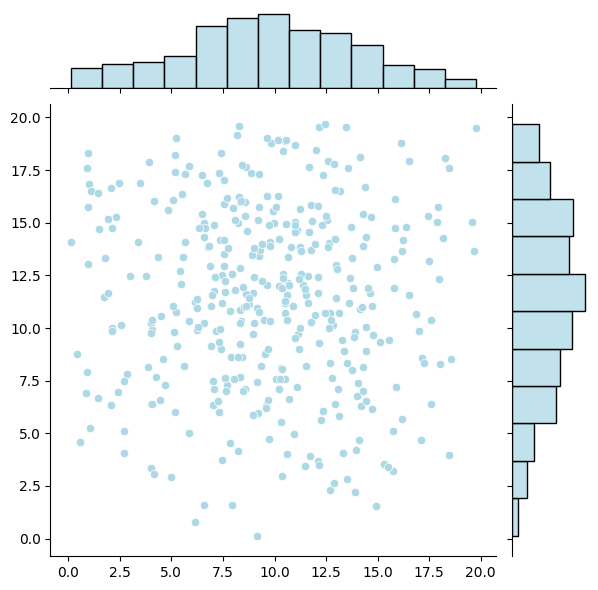

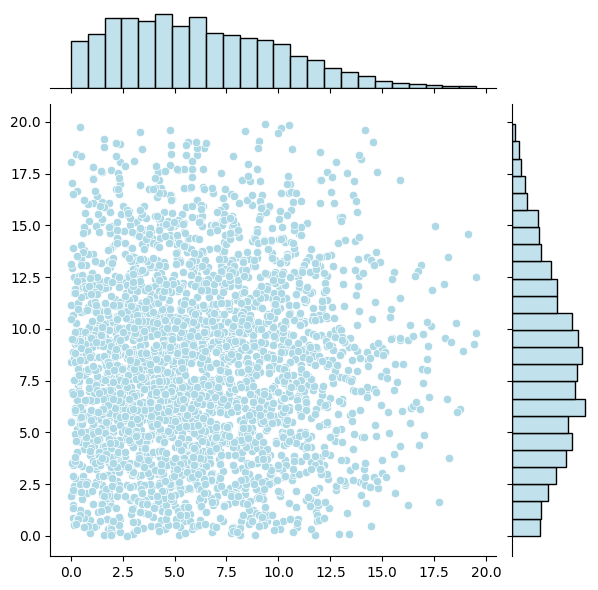

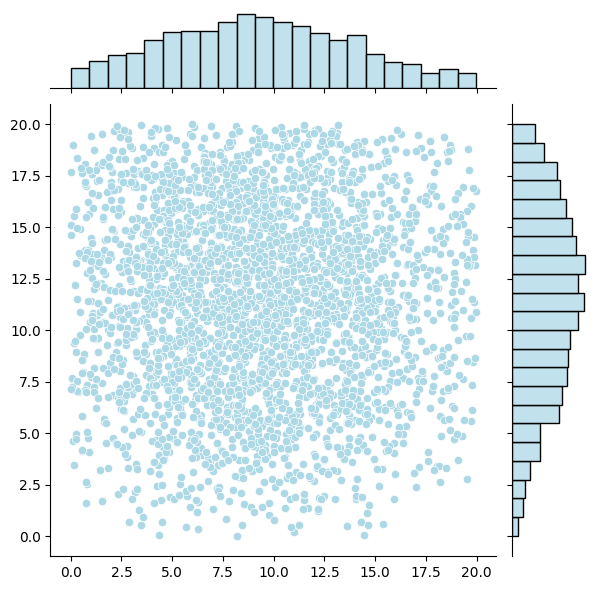

In [96]:
def plot_location_data(data, title='Location data'):
    x, y = zip(*data)
    sns.jointplot(x=x, y=y, kind='scatter'
                  , color='lightblue')
    plt.xlabel('')
    plt.ylabel('')
    filename = title.replace(' ', '_').lower()
    filename = os.path.join('./Report/figures/distribution_analysis/location_data/', filename)
    plt.savefig(f'{filename}.png')
    plt.show()

plot_location_data(driver_data['initial_location'], 'Driver initial locations')
plot_location_data(rider_data['pickup_location'], 'Rider pickup locations')
plot_location_data(rider_data['dropoff_location'], 'Rider dropoff locations')